### Installing Required Libraries

you will need to install these libraries by removing the `#` sign before `!mamba` in the code cell below.


In [1]:
# All Libraries required for this lab are listed below.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [2]:
!pip install torch

In [3]:
!pip install --upgrade torch

In [4]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.2 MB/s eta 0:00:00


Install Whisper:


In [5]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-n9phulli
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-n9phulli
  Resolved https://github.com/openai/whisper.git to commit e8622f9afc4eba139bf796c210f5c01081000472
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20230314-py3-none-any.whl size=798395 sha256=0128b05f64105c3a1f34a2c6445e49584dff86404b09adb0960801000695610e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3lqaur9k/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper


In [6]:
!pip install git+https://github.com/librosa/librosa

  Cloning https://github.com/librosa/librosa to /tmp/pip-req-build-kkcfhs1o
  Running command git clone --filter=blob:none --quiet https://github.com/librosa/librosa /tmp/pip-req-build-kkcfhs1o
  Resolved https://github.com/librosa/librosa to commit 43d4427f7a389acc79b5be3c924646701f19bb46
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Please **restart the kernel** after running the above installs.


### Importing Required Libraries



In [7]:
import torch
import whisper
import pytube
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

## Loading the models

There are five model sizes, four with English-only versions, offering speed and accuracy trade-offs. Below are the names of the available models and their approximate memory requirements and relative speed. You can use the tiny model for light weight applications, the large model if accuracy is most important, and the base or medium models for everything in between.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0EPMEN/images/whisper_models.png" width="70%">


Table Source: [openai/whisper](https://github.com/openai/whisper)


In [8]:
#model_t = whisper.load_model("tiny") #Load the tiny size model:
#model = whisper.load_model("base") #Load the base size model
model_m = whisper.load_model("medium") #Load the medium size model

100%|██████████████████████████████████████| 1.42G/1.42G [00:14<00:00, 104MiB/s]


---


## Loading the file


We start by loading an .mp4 audio file, previously uploaded to the IBM Cloud Object Storage.
To do so, we define the file path:


In [9]:
file_path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0EPMEN/20220627_140242.mp4'

Load an audio file, using `load_audio()` function. If you are using your own file, you can replace the 'file_path' with an actual name of your file, e.g., 'podcast.mp3'.


In [10]:
audio_35 = whisper.load_audio(file_path)
audio_35

array([ 0.        ,  0.        ,  0.        , ...,  0.01696777,
       -0.01504517,  0.01229858], dtype=float32)

Now, we can find the sampling interval, the distance or time between the measurements. The total time of audio sample is 35 seconds.


In [11]:
T=35

We check how many samples are in our audio file by calling the `shape()` function.


In [12]:
n_samples=audio_35.shape[0]
n_samples

559445

There are 559445 of samples in 35 seconds audio.


Now, we can find the time between samples by dividing the total time by the number of samples:


In [13]:
delta=T/n_samples
delta

6.25620034140979e-05

The time between samples is 6.25620034140979e-05. Now, we can get the sampling frequency:


In [14]:
Fs=1/delta
Fs

15984.142857142857

Now, we can get the time of each sample:


In [15]:
time=np.linspace(0,(n_samples-1)*delta,n_samples)
time

array([0.00000000e+00, 6.25620034e-05, 1.25124007e-04, ...,
       3.49998123e+01, 3.49998749e+01, 3.49999374e+01])

Finally, we can plot the amplitude with respect to time:


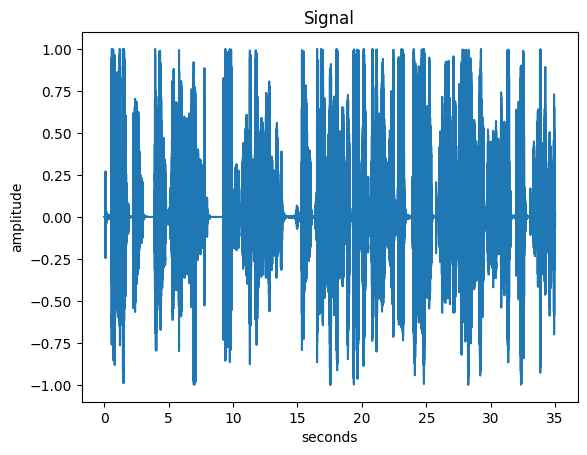

In [16]:
plt.title('Signal')
plt.plot(time,audio_35 )
plt.ylabel('amplitude')
plt.xlabel('seconds')
plt.show()


Above is a waveform for the signal. Next, we can use the `pad_or_trim()` method to ensure the sample is in the right form for inference. In our case the file is 35 seconds, so it gets trimmed to fit the 30 seconds part (30 seconds parts get fed into the encoder).


In [17]:
audio = whisper.pad_or_trim(audio_35)

We can plot the amplitude of signal over time with trimmed/padded audio:


In [18]:
n_samples=audio.shape[-1]
time=np.linspace(0,(n_samples-1)*delta,n_samples)

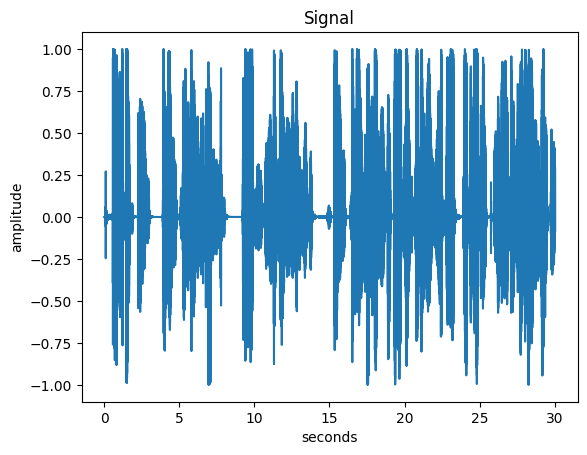

In [19]:
plt.plot(time,audio)

plt.ylabel('amplitude')
plt.xlabel('seconds')
plt.title('Signal')
plt.show()

In [20]:
mel = whisper.log_mel_spectrogram(audio).to(model_m.device)

The output above is a tensor of converted frequencies. Now, we plot 2 subplots, one is a regular representation of sound amplitude over period of time, and the other is our mel spectrogram:


Text(42.722222222222214, 0.5, 'Mel Scale')

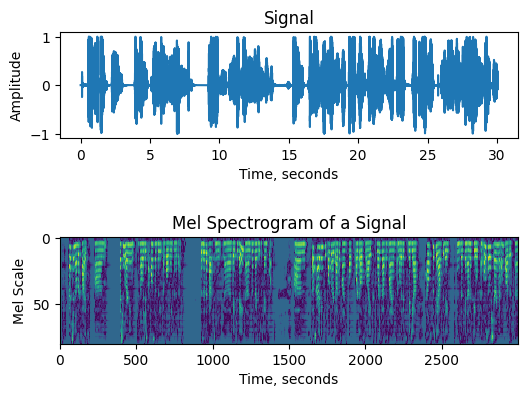

In [21]:
fig, (ax1, ax2) = plt.subplots(2)
fig.tight_layout(pad=5.0)
ax1.plot(time,audio)
ax1.set_title('Signal')
ax1.set_xlabel('Time, seconds')
ax1.set_ylabel('Amplitude')
ax2.imshow((mel.numpy()*mel.numpy())**(1/2),interpolation='nearest', aspect='auto')
ax2.set_title('Mel Spectrogram of a Signal')
ax2.set_xlabel('Time, seconds')
ax2.set_ylabel('Mel Scale')

## Language Detection
In this Example, we will listen to our audio file and detect the spoken language.


The sample rate (sr) by default is 22050, which means that for every second there are 22,050 samples. We can use `ipd.Audio()` function to listen to our audio file:


In [22]:
sr=22050
ipd.Audio(audio, rate=sr)

We can find the probability of each language by using `detect_language()` method:


In [23]:
_, probs = model_m.detect_language(mel)


We also can print the top ten languages' prefixes and their probabilities:


In [24]:
print([item  for item in  probs.items()][0:10])

[('nn', 4.106303549633594e-06), ('no', 1.5552212744296412e-06), ('sw', 8.589124718128005e-07), ('az', 3.0265812078766885e-09), ('ar', 2.083392973872833e-05), ('hy', 4.010120946418283e-08), ('sa', 1.0092140456663401e-07), ('lo', 6.157760079616992e-09), ('te', 1.616321654296371e-08), ('cs', 6.968928573769517e-06)]


Finally, we can detect the spoken language by selecting the key with the highest probability value:


In [25]:
print(f"Detected language: {max(probs, key=probs.get)}")

Detected language: en


Therefore, the spoken language is English, with 99.97% probability.


## Decoding and Transcription

The difference between decoding and transcription is that the decode function processes only 30 seconds of audio segment. Transcribe function will decode the entire audio file. Below, we decode 30-seconds audio segment(s) using `whisper.decode()` function.


In [26]:
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(model_m, mel, options)

We print the recognized text using the attribute text :


In [27]:
print(result.text)

Question number five. Machine learning technologies are constantly evolving and advancing. Does this affect me day to day and what do I do to stay informed? Subscribing to popular data science portals like Towards Data Science, Analytics, Vidya helps to stay up to date in this dynamic field and also sharing


The output of the above is a text that fits into 30 seconds audio segment. Now, the `transcribe()` method reads the entire file and processes the audio with a sliding 30-second window, performing autoregressive sequence-to-sequence predictions on each window.


In [28]:
transcription = model_m.transcribe(file_path, fp16 = False)["text"]

In [29]:
transcription

' Question number five. Machine learning technologies are constantly evolving and advancing. Does this affect me day to day and what do I do to stay informed? Subscribing to popular data science portals like Towards Data Science, Analytics, Vidya helps to stay up to date in this dynamic field and also sharing my own projects and receiving some feedback from the public expands my data science knowledge.'

## Translation

In this Example, we translate our audio file to French, by setting `language='fr'`. You can also use any other language available [here](https://github.com/openai/whisper).


In [30]:
translation = model_m.transcribe(file_path, language='fr', fp16 = False)["text"]

In [31]:
translation

" Question n°5. Les technologies de l'apprentissage de la machine sont constamment évoluées et avancées. Est-ce que cela m'affecte jour à jour? Et qu'est-ce que je fais pour rester informé? S'abonner à des portails de la science de données populaire comme le Tour de la science de la science, et aussi partager mes propres projets et recevoir des retours de la publicité, expensent ma connaissance de la science de données."

## Transcription from YouTube

Below, we will select a random YouTube video and read it using the `pytube()` library. This one is a 30 seconds Motivational Speech.


In [32]:
video_url = "https://www.youtube.com/watch?v=E9lAeMz1DaM"
data = pytube.YouTube(video_url)

We will convert and download an 'MP4' file using `streams.get_audio_only()` and `download()` functions.


In [33]:
speech = data.streams.get_audio_only()
audio_file=speech.download()
print("audio file path:",audio_file)

audio file path: /content/Motivation Quickie - This Speech Will Pump You Up in 30 Seconds.mp4


Finally, we will transcribe and translate the output to Japanese language.


In [34]:
output = model_m.transcribe(audio_file,fp16 = False,language='ja')["text"]


In [35]:
output

'あなたが持っている夢は何か知らないあなたが持っている夢はどのように不幸なことかを知らないことはないあなたが持っている夢はそれは可能だあなたが持っている夢はどのように不幸なことかを知らないことはない'